In [97]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(84).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(44).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(245).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/6.jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(238).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(196).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(108).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(310).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image (5).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(186).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(29).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(140).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(224).jpg

In [98]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import VGG16,ResNet50,inception_v3
import pandas as ps
import seaborn as sns
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.metrics import *
from PIL import Image
from tqdm import tqdm

In [99]:
img = Image.open("/kaggle/input/brain-tumor-classification-mri/Testing/glioma_tumor/image(1).jpg")
img.size

(495, 619)

# Data Splitting and Agumentation

In [100]:
labels = ["glioma_tumor","meningioma_tumor","no_tumor","pituitary_tumor"]

In [101]:
X = []
y = []


for i in labels:
    img_path = os.path.join("/kaggle/input/brain-tumor-classification-mri","Training",i)
    for j in tqdm(os.listdir(img_path)):
        img = cv2.imread(os.path.join(img_path,j))            
        img = cv2.resize(img,(224,224))
        X.append(img)
        y.append(i)

for i in labels:
    img_path = os.path.join("/kaggle/input/brain-tumor-classification-mri","Testing",i)
    for j in tqdm(os.listdir(img_path)):
        img = cv2.imread(os.path.join(img_path,j)) 
        img = cv2.resize(img,(224,224))
        X.append(img)
        y.append(i)

X = np.array(X)
y = np.array(y)

100%|██████████| 74/74 [00:00<00:00, 255.09it/s]


In [102]:
X,y = sklearn.utils.shuffle(X,y,random_state=42)

In [103]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=42)

In [104]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

# ResNet

In [105]:
resnet = ResNet50(weights='imagenet',include_top=False,input_shape=(224,224,3))

In [106]:
model = resnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=resnet.input, outputs = model)

In [107]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 23,542,788 (89.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [108]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [109]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32)

Epoch 1/12
91/91 ━━━━━━━━━━━━━━━━━━━━ 82s 388ms/step - accuracy: 0.6604 - loss: 1.1182 - val_accuracy: 0.3220 - val_loss: 102.9529
Epoch 2/12
91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 0.8999 - loss: 0.3201 - val_accuracy: 0.4582 - val_loss: 8.7935
Epoch 3/12
91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 0.9165 - loss: 0.2430 - val_accuracy: 0.5325 - val_loss: 2.0660
Epoch 4/12
91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 0.9511 - loss: 0.1497 - val_accuracy: 0.4118 - val_loss: 1.9064
Epoch 5/12
91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 0.9565 - loss: 0.1370 - val_accuracy: 0.5975 - val_loss: 2.8798
Epoch 6/12
91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 0.9698 - loss: 0.0859 - val_accuracy: 0.8669 - val_loss: 0.4267
Epoch 7/12
91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 0.9737 - loss: 0.0730 - val_accuracy: 0.6037 - val_loss: 1.9347
Epoch 8/12
91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 0.9815 - loss: 0.0607 - val_ac

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

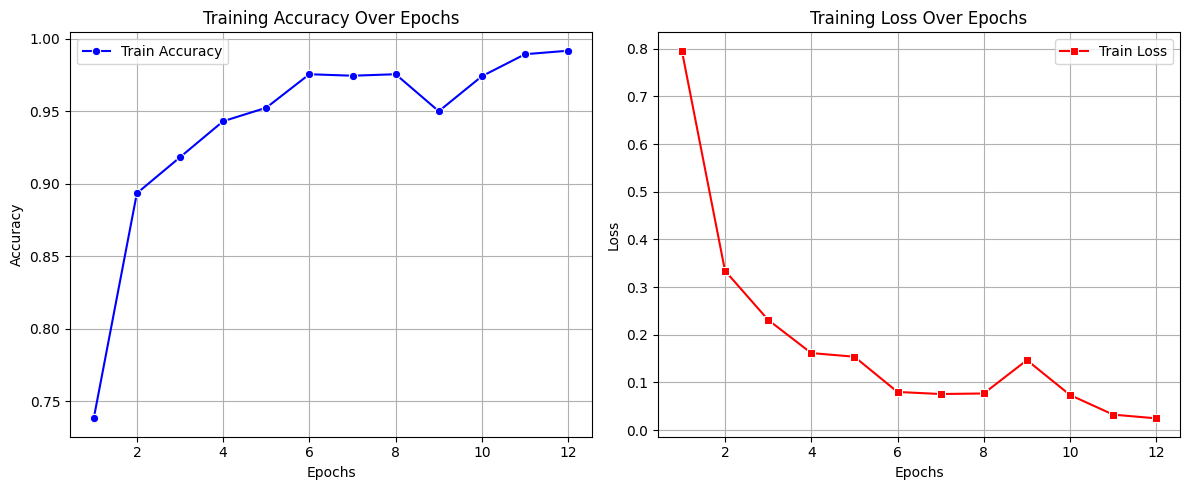

In [110]:

import matplotlib.pyplot as plt
import seaborn as sns


epochs = range(1, len(history.history['accuracy']) + 1)  
train_acc = history.history['accuracy'] 
train_loss = history.history['loss']  


fig, axes = plt.subplots(1, 2, figsize=(12, 5))


sns.lineplot(x=epochs, y=train_acc, marker="o", ax=axes[0], color="blue", label="Train Accuracy")
axes[0].set_title("Training Accuracy Over Epochs")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].grid(True)


sns.lineplot(x=epochs, y=train_loss, marker="s", ax=axes[1], color="red", label="Train Loss")
axes[1].set_title("Training Loss Over Epochs")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [111]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step


In [112]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.83      1.00      0.91        10
           2       1.00      0.86      0.92         7
           3       1.00      1.00      1.00        11

    accuracy                           0.95        42
   macro avg       0.96      0.95      0.95        42
weighted avg       0.96      0.95      0.95        42



# EfficientNetB0

In [131]:
from tensorflow.keras.applications import MobileNetV2

effnet = MobileNetV2(weights='imagenet',include_top=False,input_shape=(224,224,3))

In [132]:
efmodel = effnet.output
mod = tf.keras.layers.GlobalAveragePooling2D()(efmodel)
mod = tf.keras.layers.Dropout(0.3)(mod)
mod = tf.keras.layers.Dense(4, activation="softmax")(mod)
modell = tf.keras.models.Model(inputs=effnet.input, outputs=mod)


In [133]:
modell.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              loss= tf.keras.losses.CategoricalCrossentropy,
              metrics=['accuracy'])

In [134]:
history = modell.fit(X_train,y_train,validation_split=0.1, epochs=12, verbose=1, batch_size=32)

Epoch 1/12
91/91 ━━━━━━━━━━━━━━━━━━━━ 68s 302ms/step - accuracy: 0.7523 - loss: 0.6604 - val_accuracy: 0.1672 - val_loss: 26.5331
Epoch 2/12
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.9328 - loss: 0.2009 - val_accuracy: 0.2260 - val_loss: 18.7422
Epoch 3/12
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.9464 - loss: 0.1645 - val_accuracy: 0.1703 - val_loss: 25.0175
Epoch 4/12
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.9652 - loss: 0.1106 - val_accuracy: 0.3282 - val_loss: 9.2722
Epoch 5/12
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.9633 - loss: 0.1223 - val_accuracy: 0.1672 - val_loss: 18.2104
Epoch 6/12
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.9758 - loss: 0.0789 - val_accuracy: 0.5263 - val_loss: 3.4600
Epoch 7/12
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.9720 - loss: 0.0874 - val_accuracy: 0.3932 - val_loss: 5.7833
Epoch 8/12
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.9788 - loss: 0.0634 - val_accuracy: 0.27

In [135]:
predd = modell.predict(X_test)
preds = np.argmax(predd,axis=1)
y_test_new = np.argmax(y_test,axis=1)
print(classification_report(y_test_new,preds))

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
              precision    recall  f1-score   support

           0       1.00      0.43      0.60        14
           1       0.67      0.60      0.63        10
           2       0.32      1.00      0.48         7
           3       1.00      0.45      0.62        11

    accuracy                           0.57        42
   macro avg       0.75      0.62      0.58        42
weighted avg       0.81      0.57      0.59        42

